In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats
import matplotlib.pyplot as plt
import sqlite3 as sql
import sklearn as sklearn
import matplotlib.dates as mdates
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
import researchpy as rp

In [88]:
#loading csv file of data
gss=pd.read_csv('Project Data V3.csv')
gss.shape

(10056, 13)

### For the sake of clarity, removed a large number of unnecessary variables from the dataset that would be redundant or inapplicable. 


### New RQs: 
1) Is there a significant difference in average marital happiness between men and women in general?

2) If yes to Q1: Does the gendered discrepancy in average marital happiness differ based on political or ideological affiliation? If no to Q1: Does average marital happiness differ significantly based on political or ideological affiliation?

3) Do those with high prestige careers, on average, self-report that they are happy in their marriages more or less than those with low-prestige careers (or no career)?

4) Can a model be constructed to discriminate between the three levels of marital happiness (i.e. Low="Not Too Happy", Medium="Pretty Happy", High="Very Happy") that includes the following factors listed below:
- Sex 
- Ideological affiliation 
- Opinion of family income
- Self Career Prestige Score 
- Spouse Career Prestige Score 
- Mother Career Prestige Score (Recode as High vs. Low)

In [4]:
gss.info()
#Variable Codings
#Sex: 0=Female, 1=Male              
#Race: 1=White, 2=Black, 3=Other       
#Ideology: 1=Strongly Liberal, 2=Liberal, 3=Somewhat Liberal, 4=Moderate, 5=Somewhat Conservative, 6=Conservative, 7=Strongly Conservative
#Political: 1=Strong Dem, 2=Dem (not strong), 3=Indep (near Dem), 4=Indep, 5=Indep (near Rep), 6=Rep (not strong), 7=Strong Rep, 8=Other party
#Happymar (self-reported marital happiness): 1="Not Happy", 2="Pretty Happy", 3="Very Happy"
#Happy (self-reported happiness): 1="Not Happy", 2="Pretty Happy", 3="Very Happy"
#famincome (self-reported view of family income): 1="Far below average", 2="Below average", 3="Average", 4="Above average", 5="Far above average"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10056 entries, 0 to 10055
Data columns (total 13 columns):
ID                          10056 non-null int64
Year                        10056 non-null int64
Sex                         10056 non-null int64
Race                        10056 non-null int64
Ideology                    10056 non-null int64
Political                   10056 non-null object
Prestige                    10056 non-null int64
Sprestige                   10056 non-null int64
Mprestige                   10056 non-null int64
Dprestige                   10056 non-null int64
Happymar                    10056 non-null int64
Happy                       10056 non-null int64
Opinion of family income    10056 non-null int64
dtypes: int64(12), object(1)
memory usage: 1021.4+ KB


In [5]:
gss.describe()

,ID,Year,Sex,Race,Ideology,Prestige,Sprestige,Mprestige,Dprestige,Happymar,Happy,Opinion of family income
count,10056.000000,10056.00000,10056.000000,10056.000000,10056.000000,10056.000000,10056.000000,10056.000000,10056.000000,10056.000000,10056.000000,10056.000000
mean,5057.522574,2009.25179,0.473747,1.273667,4.146679,44.443516,42.496818,26.179793,37.543059,2.586615,2.340394,3.031325
std,2915.122888,5.80672,0.499335,0.621100,1.605394,15.353076,17.018514,22.492041,20.340672,0.553687,0.612146,0.897598
min,1.000000,2000.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2535.750000,2004.00000,0.000000,1.000000,3.000000,35.000000,35.000000,0.000000,28.750000,2.000000,2.000000,3.000000
50%,5057.500000,2010.00000,0.000000,1.000000,4.000000,45.000000,44.000000,31.000000,40.000000,3.000000,2.000000,3.000000
75%,7579.250000,2014.00000,1.000000,1.000000,5.000000,54.000000,53.000000,46.000000,49.000000,3.000000,3.000000,4.000000
max,10109.000000,2018.00000,1.000000,3.000000,7.000000,80.000000,80.000000,80.000000,80.000000,3.000000,3.000000,5.000000


In [6]:
#Double-checking for missing values in adjusted train data. Looks good!
gss.isnull().sum()

ID                          0
Year                        0
Sex                         0
Race                        0
Ideology                    0
Political                   0
Prestige                    0
Sprestige                   0
Mprestige                   0
Dprestige                   0
Happymar                    0
Happy                       0
Opinion of family income    0
dtype: int64

In [7]:
male=gss.loc[gss['Sex']==1]
fem=gss.loc[gss['Sex']==0]
male.describe()

,ID,Year,Sex,Race,Ideology,Prestige,Sprestige,Mprestige,Dprestige,Happymar,Happy,Opinion of family income
count,4764.000000,4764.000000,4764.0,4764.000000,4764.000000,4764.000000,4764.000000,4764.000000,4764.000000,4764.000000,4764.000000,4764.000000
mean,5032.032116,2009.204030,1.0,1.281276,4.251259,46.002099,40.917296,25.376784,38.085223,2.613770,2.329975,3.079345
std,2920.099455,5.816526,0.0,0.631773,1.592039,14.289426,18.595134,22.628116,20.084377,0.536968,0.617690,0.931634
min,2.000000,2000.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2461.750000,2004.000000,1.0,1.000000,4.000000,35.000000,32.000000,0.000000,31.000000,2.000000,2.000000,3.000000
50%,5018.500000,2010.000000,1.0,1.000000,4.000000,45.000000,45.000000,31.000000,40.000000,3.000000,2.000000,3.000000
75%,7549.500000,2014.000000,1.0,1.000000,6.000000,56.000000,53.000000,45.000000,49.000000,3.000000,3.000000,4.000000
max,10109.000000,2018.000000,1.0,3.000000,7.000000,80.000000,80.000000,80.000000,80.000000,3.000000,3.000000,5.000000


In [8]:
#ChiSquare Contingency table of gender and marital happiness
contingency_table=pd.crosstab(gss["Sex"],gss["Happymar"])
print('Contingency Table :\n',contingency_table)

Contingency Table :
 Happymar    1     2     3
Sex                      
0         200  1917  3175
1         122  1596  3046


In [9]:
contingency_table

Happymar,1,2,3
Sex,,,
0,200,1917,3175
1,122,1596,3046


In [10]:
#Getting observed Values
Obs_Vals = contingency_table.values 
Obs_Vals

array([[ 200, 1917, 3175],
       [ 122, 1596, 3046]])

In [11]:
#Getting expected values
b=scipy.stats.chi2_contingency(contingency_table)
Exp_Values = b[3]
Exp_Values

array([[ 169.45346062, 1848.72673031, 3273.81980907],
       [ 152.54653938, 1664.27326969, 2947.18019093]])

In [12]:
#degrees of freedom & sig level
df=b[2]
print("Degree of Freedom:",df)
alpha=0.05

Degree of Freedom: 2


In [13]:
#chi-square statistic - χ2
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Obs_Vals,Exp_Values)])
chi_stat=chi_square[0]+chi_square[1]
print("chi-square statistic:",chi_stat)

chi-square statistic: 16.94532699201052


In [14]:
#critical_value
crit_value=chi2.ppf(q=1-alpha,df=df)
print('critical value:',crit_value)

critical value: 5.991464547107979


In [15]:
#p-value
p_value=1-chi2.cdf(x=chi_stat,df=df)
print('p-value:',p_value)

p-value: 0.00020910720477429479


In [16]:
print('Significance level: ',alpha)
print('Degree of Freedom: ',df)
print('chi-square statistic:',chi_stat)
print('critical_value:',crit_value)
print('p-value:',p_value)

Significance level:  0.05
Degree of Freedom:  2
chi-square statistic: 16.94532699201052
critical_value: 5.991464547107979
p-value: 0.00020910720477429479


In [17]:
if p_value<=alpha:
    print("Reject H0: There is a relationship between sex and marital happiness")
else:
    print("Retain H0: There is no relationship between sex and marital happiness")


Reject H0: There is a relationship between sex and marital happiness


In [18]:
rp.summary_cat(gss[['Sex', 'Happymar' ]])

,Variable,Outcome,Count,Percent
0,Sex,0,5292,52.63
1,,1,4764,47.37
2,Happymar,3,6221,61.86
3,,2,3513,34.93
4,,1,322,3.20


In [19]:
table, results = rp.crosstab(gss['Sex'], gss['Happymar'], prop= 'col', test= 'chi-square')
    
table

Happymar                        
           1       2       3     All
Sex                                 
0      62.11   54.57   51.04   52.63
1      37.89   45.43   48.96   47.37
All   100.00  100.00  100.00  100.00

In [20]:
results

,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,23.2416
1,p-value =,0.0000
2,Cramer's V =,0.0481


In [21]:
log_data = gss.copy()
log_data.columns

Index(['ID', 'Year', 'Sex', 'Race', 'Ideology', 'Political', 'Prestige',
       'Sprestige', 'Mprestige', 'Dprestige', 'Happymar', 'Happy',
       'Opinion of family income'],
      dtype='object')

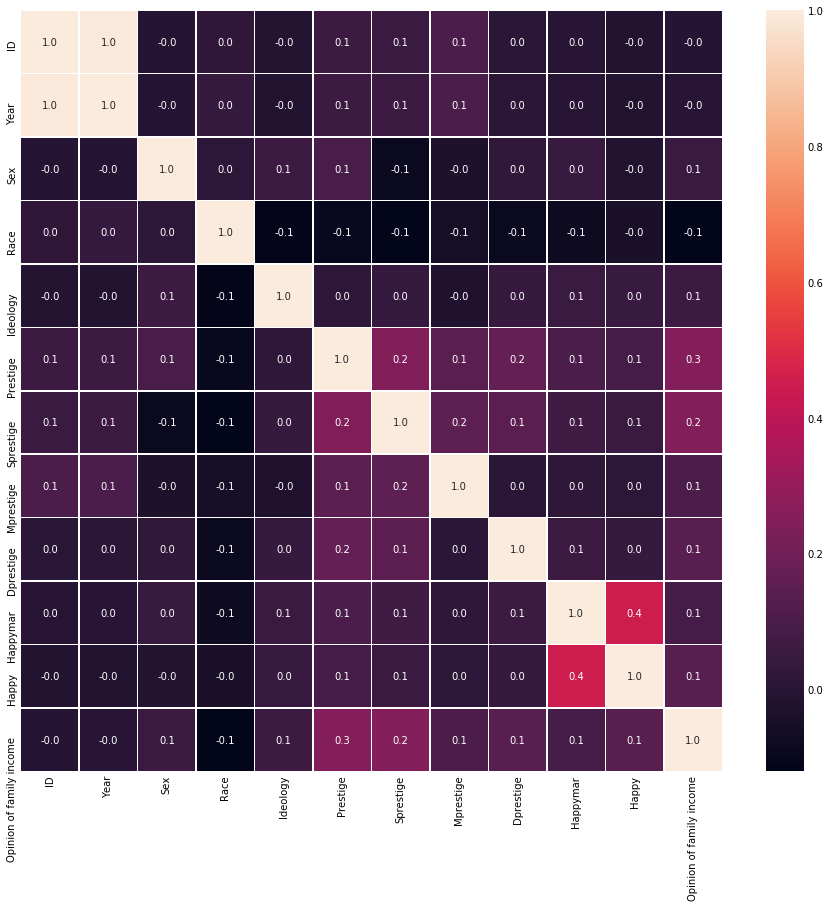

In [22]:
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(gss.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [23]:
prep=pd.get_dummies(log_data, columns=["Race","Ideology","Opinion of family income","Political","Happy"])
prep.drop("Political_Don't know", axis=1,inplace=True)
prep.drop("Political_8", axis=1,inplace=True)
prep.drop("Political_0",axis=1,inplace=True)
prep.drop("ID", axis=1,inplace=True)
prep.drop("Happy_0",axis=1,inplace=True)
prep.drop("Ideology_0",axis=1,inplace=True)
prep.drop("Opinion of family income_0",axis=1,inplace=True)
prep.columns


Index(['Year', 'Sex', 'Prestige', 'Sprestige', 'Mprestige', 'Dprestige',
       'Happymar', 'Race_1', 'Race_2', 'Race_3', 'Ideology_1', 'Ideology_2',
       'Ideology_3', 'Ideology_4', 'Ideology_5', 'Ideology_6', 'Ideology_7',
       'Opinion of family income_1', 'Opinion of family income_2',
       'Opinion of family income_3', 'Opinion of family income_4',
       'Opinion of family income_5', 'Political_1', 'Political_2',
       'Political_3', 'Political_4', 'Political_5', 'Political_6',
       'Political_7', 'Happy_1', 'Happy_2', 'Happy_3'],
      dtype='object')

In [24]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(prep.drop('Happymar',axis=1), 
           prep['Happymar'], test_size=0.30, 
            random_state=101)

Accuracy is:  0.654292343387471


/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


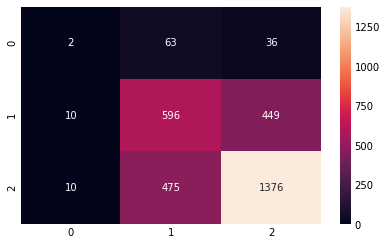

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [27]:
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [6.69876613e-02 8.94414950e+00 4.10065726e+02 2.19281334e+02
 3.10073019e+01 2.57640770e+02 1.18874355e+01 4.15060465e+01
 2.01159287e+01 6.54291013e+00 4.23561803e-02 3.53053227e+00
 1.76580904e+01 3.98614918e-01 3.47102906e+01 1.05022632e+01
 5.98574187e+01 2.66404029e+01 1.34659578e+00 2.68162570e+01
 9.03721627e-01 1.33444419e+00 1.61215081e+01 1.12080886e+01
 2.58576359e+00 1.04185128e+00 1.23016410e+01 3.37831281e+01
 5.40153250e+02 4.85217448e+02 8.50795968e+02]
Feature list: Index(['Year', 'Sex', 'Prestige', 'Sprestige', 'Mprestige', 'Dprestige',
       'Race_1', 'Race_2', 'Race_3', 'Ideology_1', 'Ideology_2', 'Ideology_3',
       'Ideology_4', 'Ideology_5', 'Ideology_6', 'Ideology_7',
       'Opinion of family income_1', 'Opinion of family income_2',
       'Opinion of family income_3', 'Opinion of family income_4',
       'Opinion of family income_5', 'Political_1', 'Political_2',
       'Political_3', 'Political_4', 'Political_5', 'Political_6',
       'Political

Accuracy is:  0.6231355651309247


/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


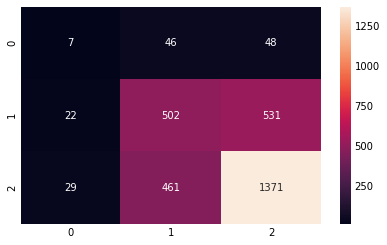

In [28]:
x_train_2 = select_feature.transform(X_train)
x_test_2 = select_feature.transform(X_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

In [ ]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

In [30]:
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['Prestige', 'Sprestige', 'Mprestige', 'Dprestige', 'Happy_3'], dtype='object')


In [ ]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)



In [32]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 22
Best features : Index(['Year', 'Sex', 'Prestige', 'Sprestige', 'Mprestige', 'Dprestige',
       'Race_1', 'Ideology_2', 'Ideology_3', 'Ideology_4', 'Ideology_5',
       'Opinion of family income_2', 'Opinion of family income_3',
       'Opinion of family income_4', 'Political_1', 'Political_2',
       'Political_4', 'Political_5', 'Political_6', 'Happy_1', 'Happy_2',
       'Happy_3'],
      dtype='object')


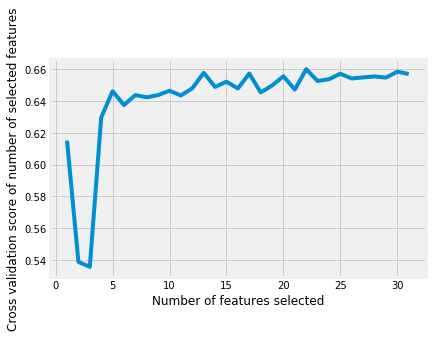

In [33]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 3 (0.122562)
2. feature 2 (0.120802)
3. feature 5 (0.116038)
4. feature 30 (0.114810)
5. feature 4 (0.093235)
6. feature 0 (0.092563)
7. feature 29 (0.049638)
8. feature 1 (0.023768)
9. feature 18 (0.018925)
10. feature 12 (0.016873)
11. feature 19 (0.015816)
12. feature 22 (0.015247)
13. feature 28 (0.014886)
14. feature 17 (0.014699)
15. feature 21 (0.014001)
16. feature 24 (0.013514)
17. feature 14 (0.013119)
18. feature 26 (0.012211)
19. feature 13 (0.011984)
20. feature 11 (0.011967)
21. feature 6 (0.011409)
22. feature 25 (0.011370)
23. feature 23 (0.011297)
24. feature 10 (0.011261)
25. feature 27 (0.009670)
26. feature 8 (0.007207)
27. feature 16 (0.007035)
28. feature 7 (0.006470)
29. feature 9 (0.006385)
30. feature 20 (0.006084)
31. feature 15 (0.005155)


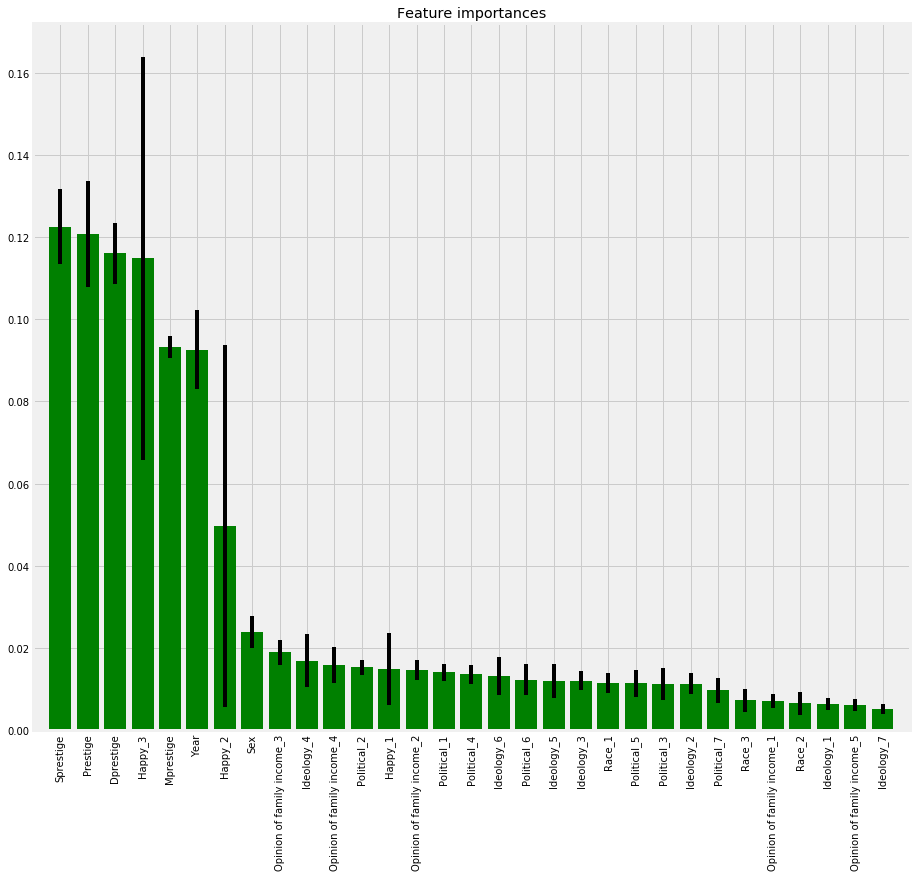

In [34]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [52]:
df=pd.read_csv('Project Data V4.csv')
df.columns

Index(['Year', 'Sex', 'Race', 'Ideology', 'Political', 'Happymar', 'Happy',
       'Opinion of family income', 'DStand', 'DPStand'],
      dtype='object')

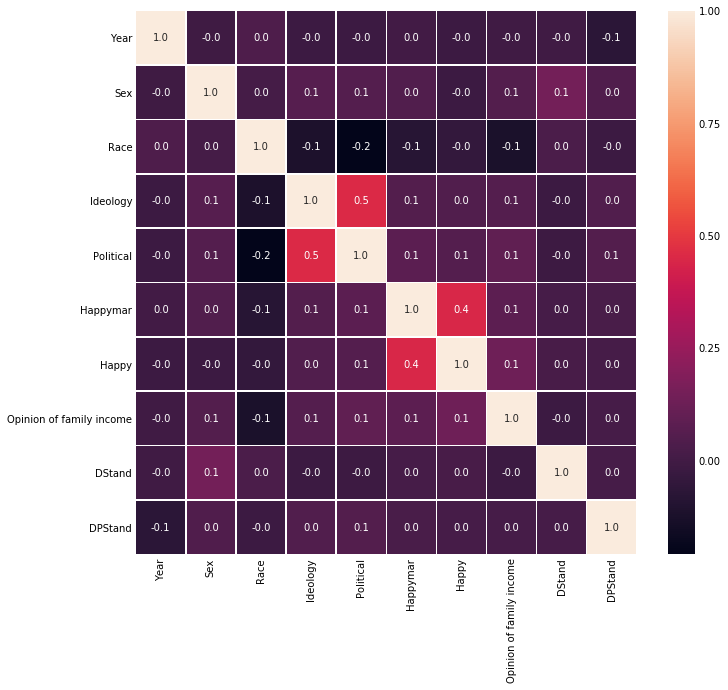

In [53]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Happymar',axis=1), 
           prep['Happymar'], test_size=0.30, 
            random_state=101)

/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is:  0.6344050381173351


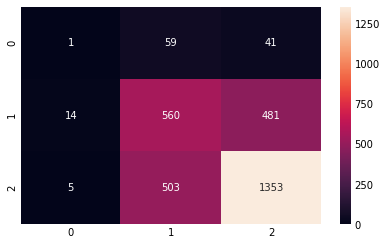

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [57]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

y_t = np.array(df['Happymar'])
X_t = df
X_t = df.drop(['Happymar'],axis=1)
X_t = np.array(X_t)

print("shape of Y :"+str(y_t.shape))
print("shape of X :"+str(X_t.shape))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X_t)

shape of Y :(10056,)
shape of X :(10056, 9)


In [58]:
X_train,X_test,Y_train,Y_test = train_test_split(X_t,y_t,test_size=.20,random_state=42)
print("shape of X Train :"+str(X_train.shape))
print("shape of X Test :"+str(X_test.shape))
print("shape of Y Train :"+str(Y_train.shape))
print("shape of Y Test :"+str(Y_test.shape))

shape of X Train :(8044, 9)
shape of X Test :(2012, 9)
shape of Y Train :(8044,)
shape of Y Test :(2012,)


In [59]:
for this_C in [1,3,5,10,40,60,80,100]:
    clf = SVC(kernel='linear',C=this_C).fit(X_train,Y_train)
    scoretrain = clf.score(X_train,Y_train)
    scoretest  = clf.score(X_test,Y_test)
    print("Linear SVM value of C:{}, training score :{:2f} , Test Score: {:2f} \n".format(this_C,scoretrain,scoretest))

Linear SVM value of C:1, training score :0.669816 , Test Score: 0.640656 

Linear SVM value of C:3, training score :0.666211 , Test Score: 0.654076 

Linear SVM value of C:5, training score :0.672427 , Test Score: 0.647614 

Linear SVM value of C:10, training score :0.671432 , Test Score: 0.645626 

Linear SVM value of C:40, training score :0.674167 , Test Score: 0.640159 

Linear SVM value of C:60, training score :0.676156 , Test Score: 0.645129 

Linear SVM value of C:80, training score :0.675535 , Test Score: 0.650099 

Linear SVM value of C:100, training score :0.677772 , Test Score: 0.642644 



In [60]:
from sklearn.model_selection import cross_val_score,StratifiedKFold,LeaveOneOut
clf1 = SVC(kernel='linear',C=20).fit(X_train,Y_train)
scores = cross_val_score(clf1,X_train,Y_train,cv=5)
strat_scores = cross_val_score(clf1,X_train,Y_train,cv=StratifiedKFold(5,random_state=10,shuffle=True))
#Loo = LeaveOneOut()
#Loo_scores = cross_val_score(clf1,X_train,Y_train,cv=Loo)
print("The Cross Validation Score :"+str(scores))
print("The Average Cross Validation Score :"+str(scores.mean()))
print("The Stratified Cross Validation Score :"+str(strat_scores))
print("The Average Stratified Cross Validation Score :"+str(strat_scores.mean()))
#print("The LeaveOneOut Cross Validation Score :"+str(Loo_scores))
#print("The Average LeaveOneOut Cross Validation Score :"+str(Loo_scores.mean()))

The Cross Validation Score :[0.6826087  0.67122436 0.65755127 0.68034826 0.64676617]
The Average Cross Validation Score :0.6676997521109023
The Stratified Cross Validation Score :[0.6484472  0.65692977 0.6774394  0.66231343 0.68905473]
The Average Stratified Cross Validation Score :0.6668369075145103


In [61]:
from sklearn.dummy import DummyClassifier

for strat in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy_maj = DummyClassifier(strategy=strat).fit(X_train,Y_train)
    print("Train Stratergy :{} \n Score :{:.2f}".format(strat,dummy_maj.score(X_train,Y_train)))
    print("Test Stratergy :{} \n Score :{:.2f}".format(strat,dummy_maj.score(X_test,Y_test)))

Train Stratergy :stratified 
 Score :0.51
Test Stratergy :stratified 
 Score :0.51
Train Stratergy :most_frequent 
 Score :0.62
Test Stratergy :most_frequent 
 Score :0.62
Train Stratergy :prior 
 Score :0.62
Test Stratergy :prior 
 Score :0.62
Train Stratergy :uniform 
 Score :0.33
Test Stratergy :uniform 
 Score :0.34


In [67]:
X = np.array(df.iloc[:,[0,9]])
y = np.array(df['Happymar'])
print("Shape of X:"+str(X.shape))
print("Shape of y:"+str(y.shape))
X = scaler.fit_transform(X)

Shape of X:(10056, 2)
Shape of y:(10056,)


In [68]:
from matplotlib.colors import ListedColormap
cm_dark = ListedColormap(['#ff6060', '#8282ff','#ffaa00','#fff244','#4df9b9','#76e8fc','#3ad628'])
cm_bright = ListedColormap(['#ffafaf', '#c6c6ff','#ffaa00','#ffe2a8','#bfffe7','#c9f7ff','#9eff93'])

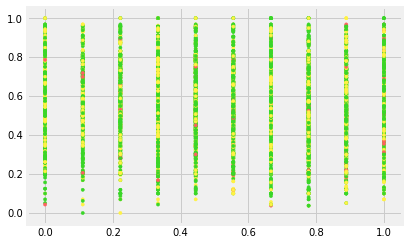

In [69]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_dark,s=10,label=y)
plt.show()

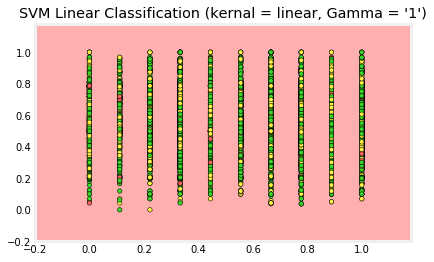

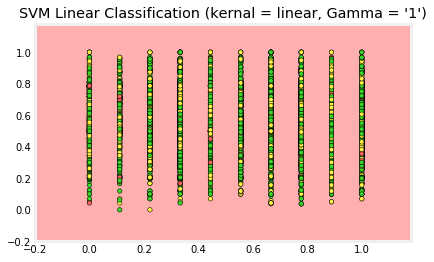

In [70]:
h = .02  # step size in the mesh
C_param = 1 # No of neighbours
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf1 = SVC(kernel='linear',C=C_param)
    clf1.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min()-.20, X[:, 0].max()+.20
    y_min, y_max = X[:, 1].min()-.20, X[:, 1].max()+.20
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])   # ravel to flatten the into 1D and c_ to concatenate 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("SVM Linear Classification (kernal = linear, Gamma = '%s')"% (C_param))

plt.show()

In [71]:
print("The score of the above :"+str(clf1.score(X,y)))

The score of the above :0.6186356404136834


In [72]:
from sklearn.svm import LinearSVC

for this_C in [1,3,5,10,40,60,80,100]:
    clf2 = LinearSVC(C=this_C).fit(X_train,Y_train)
    scoretrain = clf2.score(X_train,Y_train)
    scoretest  = clf2.score(X_test,Y_test)
    print("Linear SVM value of C:{}, training score :{:2f} , Test Score: {:2f} \n".format(this_C,scoretrain,scoretest))

Linear SVM value of C:1, training score :0.648185 , Test Score: 0.635686 

Linear SVM value of C:3, training score :0.648558 , Test Score: 0.635686 



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM value of C:5, training score :0.648807 , Test Score: 0.635686 



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM value of C:10, training score :0.649055 , Test Score: 0.635189 



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM value of C:40, training score :0.634635 , Test Score: 0.634195 



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM value of C:60, training score :0.640229 , Test Score: 0.639662 



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM value of C:80, training score :0.641721 , Test Score: 0.635686 

Linear SVM value of C:100, training score :0.629289 , Test Score: 0.623260 



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [73]:
from sklearn.svm import SVR

svr = SVR(kernel='linear',C=1,epsilon=.01).fit(X_train,Y_train)
print("{:.2f} is the accuracy of the SV Regressor".format(svr.score(X_train,Y_train)))

0.17 is the accuracy of the SV Regressor


In [74]:
for this_C in [1,5,10,25,50,100]:
    clf3 = SVC(kernel='rbf',C=this_C).fit(X_train,Y_train)
    clf3train = clf3.score(X_train,Y_train)
    clf3test  = clf3.score(X_test,Y_test)
    print("SVM for Non Linear \n C:{} Training Score : {:2f} Test Score : {:2f}\n".format(this_C,clf3train,clf3test))

/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM for Non Linear 
 C:1 Training Score : 0.680134 Test Score : 0.651590



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM for Non Linear 
 C:5 Training Score : 0.680010 Test Score : 0.651590



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM for Non Linear 
 C:10 Training Score : 0.679637 Test Score : 0.655070



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM for Non Linear 
 C:25 Training Score : 0.679637 Test Score : 0.653082



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM for Non Linear 
 C:50 Training Score : 0.679637 Test Score : 0.650099



/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM for Non Linear 
 C:100 Training Score : 0.681377 Test Score : 0.651093



In [75]:
for this_gamma in [.1,.5,.10,.25,.50,1]:
    for this_C in [1,5,7,10,15,25,50]:
        clf3 = SVC(kernel='rbf',C=this_C,gamma=this_gamma).fit(X_train,Y_train)
        clf3train = clf3.score(X_train,Y_train)
        clf3test  = clf3.score(X_test,Y_test)
        print("SVM for Non Linear \n Gamma: {} C:{} Training Score : {:2f} Test Score : {:2f}\n".format(this_gamma,this_C,clf3train,clf3test))

SVM for Non Linear 
 Gamma: 0.1 C:1 Training Score : 0.680632 Test Score : 0.652087

SVM for Non Linear 
 Gamma: 0.1 C:5 Training Score : 0.679388 Test Score : 0.650596

SVM for Non Linear 
 Gamma: 0.1 C:7 Training Score : 0.680880 Test Score : 0.653579

SVM for Non Linear 
 Gamma: 0.1 C:10 Training Score : 0.680880 Test Score : 0.652087

SVM for Non Linear 
 Gamma: 0.1 C:15 Training Score : 0.679140 Test Score : 0.652087

SVM for Non Linear 
 Gamma: 0.1 C:25 Training Score : 0.679264 Test Score : 0.651590

SVM for Non Linear 
 Gamma: 0.1 C:50 Training Score : 0.680134 Test Score : 0.649602

SVM for Non Linear 
 Gamma: 0.5 C:1 Training Score : 0.682248 Test Score : 0.651093

SVM for Non Linear 
 Gamma: 0.5 C:5 Training Score : 0.683988 Test Score : 0.651590

SVM for Non Linear 
 Gamma: 0.5 C:7 Training Score : 0.683491 Test Score : 0.650099

SVM for Non Linear 
 Gamma: 0.5 C:10 Training Score : 0.683988 Test Score : 0.650596

SVM for Non Linear 
 Gamma: 0.5 C:15 Training Score : 0.6849

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1,5,7,10,15,25,50],
              'gamma': [.1,.5,.10,.25,.50,1]}
GS = GridSearchCV(SVC(kernel='rbf'),param_grid,cv=5)

In [77]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df2=pd.read_csv('Project Data V5.csv')

In [117]:
X=df2.drop(['Happymar'], axis=1)
y=df2['Happymar']
onehotX = pd.get_dummies(X)
onehotY = pd.get_dummies(y)

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(onehotX, 
           y, test_size=0.30, 
            random_state=101)

Accuracy is:  0.646005966191581


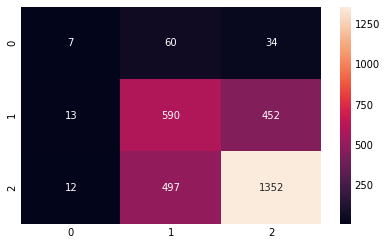

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [173]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=15).fit(X_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [6.69876613e-02 4.10065726e+02 2.19281334e+02 3.10073019e+01
 2.57640770e+02 5.14450818e+00 8.18724324e+00 8.94414950e+00
 4.15060465e+01 2.01159287e+01 1.18874355e+01 3.47102906e+01
 6.54291013e+00 1.05022632e+01 4.23561803e-02 1.92855613e+01
 3.98614918e-01 3.53053227e+00            nan 1.12080886e+01
 1.04185128e+00 1.87019051e+00 1.61215081e+01 1.23016410e+01
 1.62401574e-01 1.33444419e+00 3.37831281e+01 5.40153250e+02
 4.84304693e+02 8.50795968e+02 2.68162570e+01 1.70469628e+00
 2.66404029e+01 9.03721627e-01 5.98574187e+01]
Feature list: Index(['Year', 'Prestige', 'Sprestige', 'Mprestige', 'Dprestige', 'Socpos',
       'Sex_Female', 'Sex_Male', 'Race_Black', 'Race_Other', 'Race_White',
       'Ideology_Conservative', 'Ideology_Extremely liberal',
       'Ideology_Extrmly conservative', 'Ideology_Liberal',
       'Ideology_Moderate', 'Ideology_Slghtly conservative',
       'Ideology_Slightly liberal', 'Political_Don't know',
       'Political_Ind,near dem', 'Political_I

Accuracy is:  0.6503148823334438


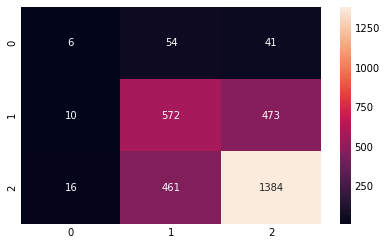

In [181]:
x_train_2 = select_feature.transform(X_train)
x_test_2 = select_feature.transform(X_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

In [125]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['Prestige', 'Sprestige', 'Mprestige', 'Dprestige', 'Happy_Very happy'], dtype='object')


In [131]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=10,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 16
Best features : Index(['Year', 'Prestige', 'Sprestige', 'Mprestige', 'Dprestige', 'Socpos',
       'Sex_Female', 'Ideology_Moderate', 'Political_Independent',
       'Political_Not str democrat', 'Political_Not str republican',
       'Political_Strong democrat', 'Happy_Pretty happy', 'Happy_Very happy',
       'Opinion of family income_Above average',
       'Opinion of family income_Average'],
      dtype='object')


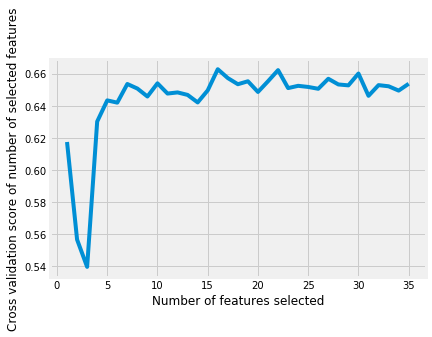

In [132]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Feature ranking:
1. feature 1 (0.117251)
2. feature 2 (0.111396)
3. feature 4 (0.107918)
4. feature 29 (0.100837)
5. feature 3 (0.083935)
6. feature 0 (0.081035)
7. feature 28 (0.062079)
8. feature 5 (0.057878)
9. feature 27 (0.017709)
10. feature 15 (0.017214)
11. feature 31 (0.016730)
12. feature 6 (0.014889)
13. feature 21 (0.014463)
14. feature 16 (0.013102)
15. feature 30 (0.013076)
16. feature 7 (0.012880)
17. feature 22 (0.012787)
18. feature 32 (0.012116)
19. feature 25 (0.012014)
20. feature 19 (0.011818)
21. feature 11 (0.011431)
22. feature 23 (0.011098)
23. feature 17 (0.010589)
24. feature 14 (0.010392)
25. feature 20 (0.009941)
26. feature 10 (0.009539)
27. feature 26 (0.009132)
28. feature 13 (0.005975)
29. feature 12 (0.005552)
30. feature 9 (0.005447)
31. feature 34 (0.005425)
32. feature 8 (0.005295)
33. feature 33 (0.005010)
34. feature 24 (0.004047)
35. feature 18 (0.000000)


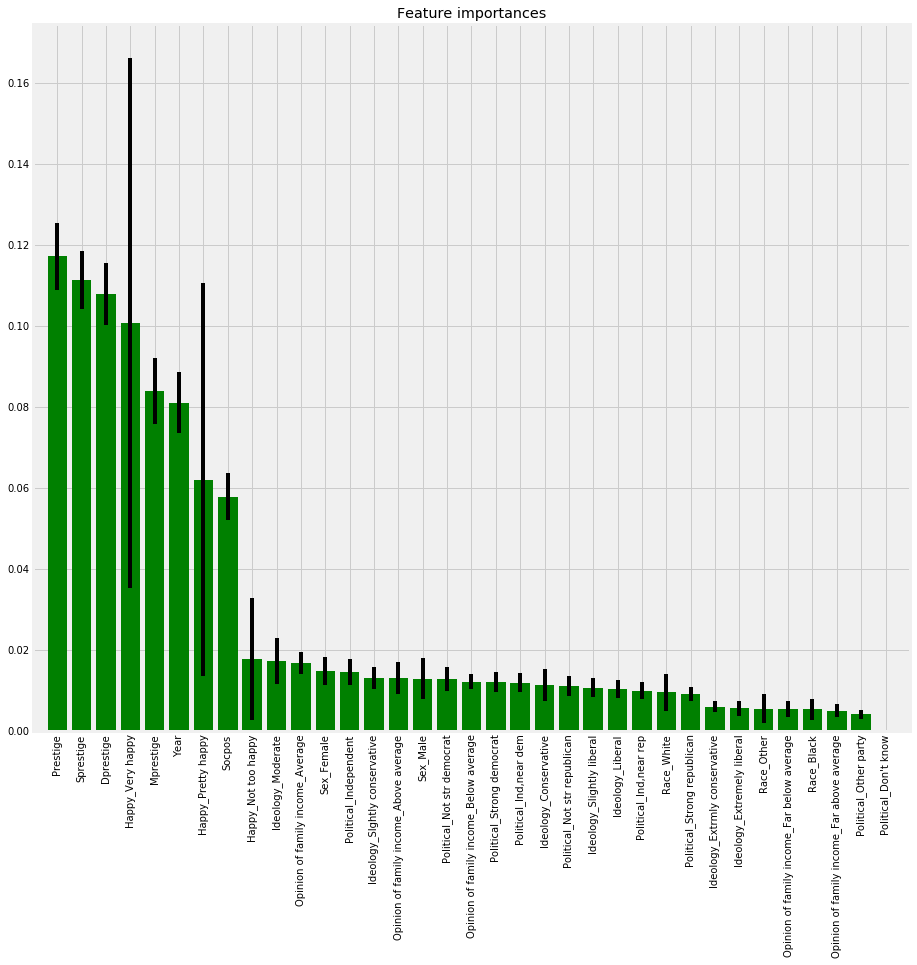

In [168]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()